>[Introduction](#scrollTo=aq_aUh_SJ6lu)

>[Importing input and displaying data](#scrollTo=aq_aUh_SJ6lu)

>>[Graphical Support](#scrollTo=bBcqfC9oMZwC)

>>[Add suplementary data](#scrollTo=0XzSoLClMkKj)

>>[Create two more data frames](#scrollTo=c_aQc4ztM6Nl)

>>[Compare Existing vs New Customers renewal rate and contract length](#scrollTo=I68Hy8EUenBp)

>>>[Trends](#scrollTo=I68Hy8EUenBp)

>>[What is Renewal Frequency of Loyal Customers?](#scrollTo=MWf6EuCBbgrc)

>>>[Trends](#scrollTo=MWf6EuCBbgrc)

>>[How do renewals fluctuate through the year?](#scrollTo=DnBPqUliLrje)

>>>[Trends](#scrollTo=DnBPqUliLrje)

>>[Which weekdays are effective for renewals?](#scrollTo=d0rc3wr0Jwr9)

>>>[Trends](#scrollTo=d0rc3wr0Jwr9)

>>[Who are my top performaing agents overall?](#scrollTo=umrrKlMnj3aZ)

>>>[Trends](#scrollTo=umrrKlMnj3aZ)

>>[Which agent renews existing customers more (loyalty rate)?](#scrollTo=Qvl5TmMW0b7q)

>>>[Trends](#scrollTo=Qvl5TmMW0b7q)

>>[Which stores are leading renewals?](#scrollTo=ljGW5bn5nO-F)

>>>[Trends](#scrollTo=ljGW5bn5nO-F)

>>[Which stores foster loyalty in customers base?](#scrollTo=zdiEA1JE1WNU)

>>>[Trends](#scrollTo=zdiEA1JE1WNU)

>[Summary](#scrollTo=H9HMzUgAOHrB)



# Introduction

This data analysis work is being performed for limited data analysis for an agency with a subscription based service model. Agency wants to find out underlying trends of the data and what can be done to improve the business (acquiring new members and improving retention rate).

# Importing input and displaying data
We used google colab as infrastructure to perform the analysis. Google Colab is designed to help disseminate machine learning education and research. First we import excel input from google drive shared with us. Libraries used were google.colab and pydrive to mount and authenticate drive and load data in our notebook. We'd load data analysis library including numpy and pandas and matplot for graphical support.

In [0]:
#@title
!pip install --upgrade google-api-python-client
!pip install -U -q PyDrive

from google.colab import files
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#@title

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np

In [0]:
#@title
csv_id = '15l5gcjEqNiokhpK5yRUDyyRG32BsXJkF'

gdrive_file = drive.CreateFile({'id':csv_id})
gdrive_file.FetchMetadata()
csv_contents = gdrive_file.GetContentString()


In [5]:
#@title
import sys
if sys.version_info[0] < 3: 
    from StringIO import StringIO
else:
    from io import StringIO
import pandas as pd

df = pd.read_table(StringIO(csv_contents), sep=",")
#display(df[:5])
df.describe()

,ID,Months_in_contract,Renewal_count
count,4.435000e+03,4436.000000,4436.000000
mean,3.528286e+14,6.744139,4.516456
std,4.758599e+13,2.154181,2.750824
min,3.521141e+14,0.000000,0.000000
25%,3.521141e+14,5.000000,2.000000
50%,3.521141e+14,7.000000,5.000000
75%,3.521141e+14,8.000000,7.000000
max,3.521141e+15,13.000000,11.000000


## Graphical Support
In this section, we define some routines to analyze our data.

In [0]:
#@title
def show_histogram(df1, columns_x, b=12, df2=pd.DataFrame()):
  bins = [i for i in range(b)]
  plt.figure(figsize=(10,10))
  all_x = ''
  for x in columns_x:
    plt.hist(df1[x],label=x,bins=bins, 
             ls='dashed', lw=3, fc=(0, 0, 1, 0.5))
    if ( df2.empty == False ):
      plt.hist(df2[x],label=x+'_new',bins=bins,
               ls='dotted', lw=3, fc=(1, 0, 1, 0.5))
    all_x += x + ' '
  plt.title(' Histogram for '+all_x)
  plt.xlabel(all_x)
  plt.ylabel('Count')
  plt.legend()
  plt.show()
      
def show_scatter(df, columns_x, columns_y, sort_x=True):
  for x in columns_x:
    for y in columns_y:
      if ( x == y ):
        continue
      df1 = df
      if ( sort_x == True ): 
        df1 = df.sort_values(by=[x])
      plt.figure(figsize=(10,10))
      plt.plot(df1[x], df1[y], 'r.', alpha=0.5)
      plt.title(x+' vs '+y)
      plt.xlabel(x)
      plt.ylabel(y)
      plt.grid(linestyle='-', linewidth=1)
      plt.show()

def show_3D_bars(df, x, y, bins=12):

  fig = plt.figure(figsize=(10,10))
  ax = fig.gca(projection='3d')

  hist, xedges, yedges = np.histogram2d(df[x], df[y], 
                                        bins=bins, 
                                        range=[[0, bins], [0, bins]])

  xpos, ypos = np.meshgrid(xedges[:-1] + 0.25, yedges[:-1] + 0.25)
  xpos = xpos.flatten('F')
  ypos = ypos.flatten('F')
  zpos = np.zeros_like(xpos)

  # Construct arrays with the dimensions for the 16 bars.
  dx = 0.5 * np.ones_like(zpos)
  dy = dx.copy()
  dz = hist.flatten()

  ax.bar3d(xpos, ypos, zpos, dx, dy, dz, color='magenta', zsort='average')
  ax.set_xlabel(x)
  ax.set_ylabel(y)
  ax.set_zlabel('Count')

  plt.show()

def show_largeDots(df1, x, y, df2=pd.DataFrame()):

  plt.figure(figsize=(10,10))

  scale = lambda x : (((x-x.min())/float(x.max()-x.min())+1)*15)**2  
  u_new, new_count = np.unique(np.c_[df1[x], df1[y]],
                               return_counts=True, axis=0)

  plt.scatter(df1[x], df1[y], c='b', marker='o', s=scale(new_count), 
              label='New', alpha=0.4)
  
  if ( df2.empty == False ):
      u_existing, existing_count = np.unique(np.c_[df2[x], df2[y]],
                                             return_counts=True, axis=0)
      plt.scatter(df2[x], df2[y], c='r', marker='o', 
                  s=scale(existing_count), label='Existing', alpha=0.4)


  plt.title(x+' vs '+y)
  plt.xlabel(x)
  plt.ylabel(y)
  plt.grid(linestyle='-', linewidth=1)
  plt.legend()
  plt.show()

## Add suplementary data
We'll add 16 different data types derived from existing data

In [7]:
#@title
# Add 16 more columns

df['Activation_DD']        = pd.DatetimeIndex(df['Activation_date']).day
df['Activation_month']     = pd.DatetimeIndex(df['Activation_date']).month
df['Activation_year']      = pd.DatetimeIndex(df['Activation_date']).year
df['Activation_weekday']   = pd.DatetimeIndex(df['Activation_date']).dayofweek
df['Last_renewal_DD']      = pd.DatetimeIndex(df['Last_renewal_date']).day
df['Last_renewal_month']   = pd.DatetimeIndex(df['Last_renewal_date']).month
df['Last_renewal_year']    = pd.DatetimeIndex(df['Last_renewal_date']).year
df['Last_renewal_weekday'] = pd.DatetimeIndex(df['Last_renewal_date']).dayofweek
df['Approved_DD']          = pd.DatetimeIndex(df['Approved Date']).day
df['Approved_month']       = pd.DatetimeIndex(df['Approved Date']).month
df['Approved_year']        = pd.DatetimeIndex(df['Approved Date']).year
df['Approved_weekday']     = pd.DatetimeIndex(df['Approved Date']).dayofweek

display(df[:5])

,ID,Months_in_contract,Store,Renewal_count,Activation_date,Last_renewal_date,Approved Date,Activator,Activation Type,Activation_DD,...,Activation_year,Activation_weekday,Last_renewal_DD,Last_renewal_month,Last_renewal_year,Last_renewal_weekday,Approved_DD,Approved_month,Approved_year,Approved_weekday
0,3.521141e+14,6,AI STORE ADEOLA ODEKU,1,23-Jun-2017 10:23:40,01-Aug-2017 11:09:06,23-Jun-2017 09:47:21,ADEH,Existing,23,...,2017,4,1,8,2017,1,23,6,2017,4
1,3.521141e+14,5,AI LAGOS IKORODU,0,01-Aug-2017 12:28:12,01-Aug-2017 12:28:12,01-Aug-2017 11:01:21,DAUM,New,1,...,2017,1,1,8,2017,1,1,8,2017,1
2,3.521141e+14,5,YES MOBILE LEKKI PHASE 1,0,01-Aug-2017 14:14:27,01-Aug-2017 14:14:27,01-Aug-2017 13:06:43,NNOD,New,1,...,2017,1,1,8,2017,1,1,8,2017,1
3,3.521141e+14,5,AI SHOPRITE ENUGU,0,01-Aug-2017 14:34:49,01-Aug-2017 14:34:49,01-Aug-2017 14:11:30,DAUG,Existing,1,...,2017,1,1,8,2017,1,1,8,2017,1
4,3.521141e+14,6,AI UYO,1,29-Jun-2017 09:38:35,01-Aug-2017 17:09:26,29-Jun-2017 09:06:00,JOUD,New,29,...,2017,3,1,8,2017,1,29,6,2017,3


## Create two more data frames
We create two more data frames for clear understanding and analysis of trends.


1.   New Business
2.   Existing Business



In [8]:
#@title

df_new= df.loc[df['Activation Type'] == 'New  '].copy()
df_new.describe()


,ID,Months_in_contract,Renewal_count,Activation_DD,Activation_month,Activation_year,Activation_weekday,Last_renewal_DD,Last_renewal_month,Last_renewal_year,Last_renewal_weekday,Approved_DD,Approved_month,Approved_year,Approved_weekday
count,2.333000e+03,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000,2334.000000
mean,3.521141e+14,6.459726,4.128106,16.145244,6.077978,2016.997858,2.199657,16.016281,7.634533,2017.275064,2.802485,16.236932,6.051414,2016.997001,2.087404
std,3.639390e+04,2.183179,2.640050,8.772785,2.189071,0.068632,1.397591,8.713406,4.628934,0.447601,1.897270,8.695890,2.190247,0.074587,1.374897
min,3.521141e+14,0.000000,0.000000,1.000000,1.000000,2016.000000,0.000000,1.000000,1.000000,2016.000000,0.000000,1.000000,1.000000,2016.000000,0.000000
25%,3.521141e+14,5.000000,2.000000,8.000000,5.000000,2017.000000,1.000000,9.000000,1.000000,2017.000000,1.000000,9.000000,5.000000,2017.000000,1.000000
50%,3.521141e+14,6.000000,4.000000,16.000000,6.000000,2017.000000,2.000000,16.000000,10.000000,2017.000000,3.000000,16.000000,6.000000,2017.000000,2.000000
75%,3.521141e+14,8.000000,6.000000,24.000000,7.000000,2017.000000,3.000000,23.000000,12.000000,2018.000000,4.000000,24.000000,7.000000,2017.000000,3.000000
max,3.521141e+14,13.000000,11.000000,31.000000,12.000000,2018.000000,6.000000,31.000000,12.000000,2018.000000,6.000000,31.000000,12.000000,2018.000000,4.000000


In [9]:
#@title
df_existing = df.loc[df['Activation Type'] == 'Existing  '].copy()
df_existing.describe()

,ID,Months_in_contract,Renewal_count,Activation_DD,Activation_month,Activation_year,Activation_weekday,Last_renewal_DD,Last_renewal_month,Last_renewal_year,Last_renewal_weekday,Approved_DD,Approved_month,Approved_year,Approved_weekday
count,2.093000e+03,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000,2093.000000
mean,3.536282e+14,7.057812,4.946488,16.540373,5.526039,2016.991878,2.153368,15.809365,7.170091,2017.321548,2.796942,16.458672,5.524128,2016.989489,2.068801
std,6.926938e+13,2.078756,2.807223,8.534259,2.086081,0.089779,1.433645,8.584440,4.794508,0.468204,1.909609,8.503168,2.098897,0.102008,1.395858
min,3.521141e+14,1.000000,0.000000,1.000000,1.000000,2016.000000,0.000000,1.000000,1.000000,2016.000000,0.000000,1.000000,1.000000,2016.000000,0.000000
25%,3.521141e+14,6.000000,3.000000,9.000000,4.000000,2017.000000,1.000000,9.000000,1.000000,2017.000000,1.000000,9.000000,4.000000,2017.000000,1.000000
50%,3.521141e+14,7.000000,5.000000,17.000000,5.000000,2017.000000,2.000000,16.000000,9.000000,2017.000000,3.000000,17.000000,5.000000,2017.000000,2.000000
75%,3.521141e+14,8.000000,7.000000,23.000000,7.000000,2017.000000,3.000000,23.000000,12.000000,2018.000000,4.000000,23.000000,7.000000,2017.000000,3.000000
max,3.521141e+15,13.000000,11.000000,31.000000,12.000000,2017.000000,6.000000,31.000000,12.000000,2018.000000,6.000000,31.000000,12.000000,2017.000000,5.000000


## Compare Existing vs New Customers renewal rate and contract length
From the two tables above:

|            x        | Existing_Average | Exsting_Sigma |  New_Average | New_Sigma |
|---------------------|------------------|---------------|--------------|-----------|
| Months_in_contract:	|        7.05      |      2.07     |      6.45    |    2.18   |
| Renewal_count     : |        4.95      |      2.80     |      4.13    |    2.64   |


---
### Trends
1. On the average, existing customers stay in contract about 10% longer than new customers. (7mo. vs 6mo.)
2. On the average, existing customers    renew about   about 20% more than new customers.   (5mo. vs 4mo.)
3. On the spread (variance), 50% of existing customers stay in contract upto 7months with 5 renewals.
4. On the spread (variance), 50% of New      customers stay in contract upto 6months with 4 renewals.




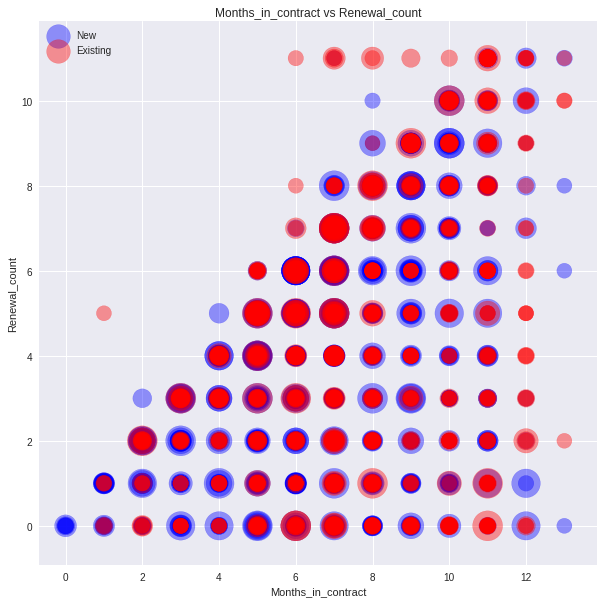

In [10]:
#@title
x = 'Months_in_contract'
y = 'Renewal_count'
show_largeDots(df_new, x, y, df_existing)

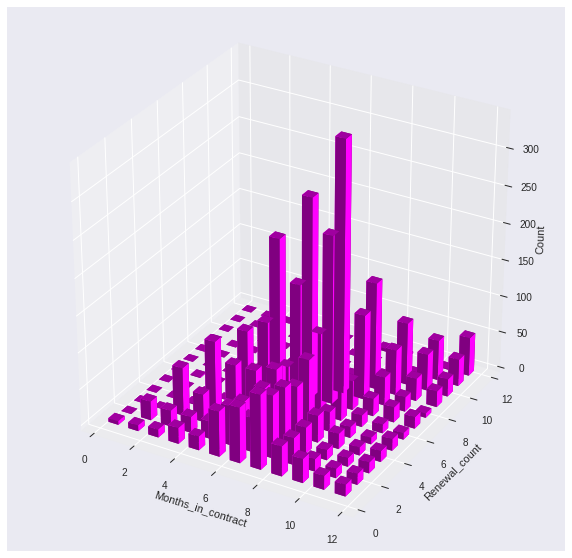

In [11]:
#@title
# renewal frequency of loyal customer (Months_in_contract vs Renewal_count)

x = 'Months_in_contract'
y = 'Renewal_count'
show_3D_bars(df, x, y)

## What is Renewal Frequency of Loyal Customers?

### Trends
1.   Highest renewal count is during the months of Jun-Aug with members 6-9 months in contract.
2.   Very high percentage of members are with 6-9 month of contract.



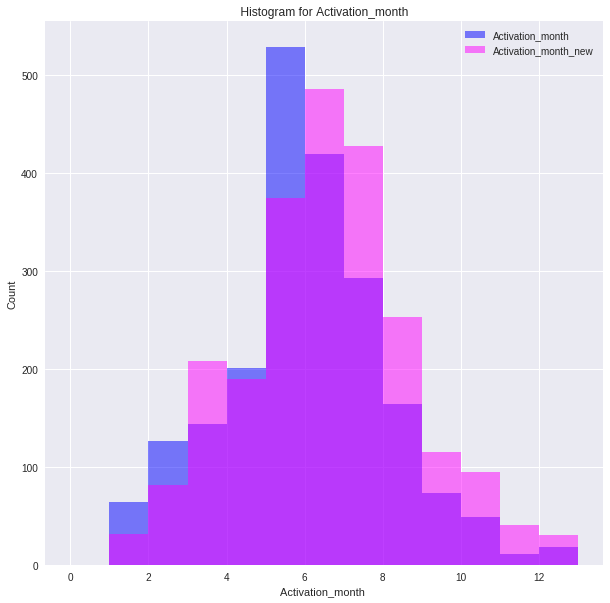

(2093, 21)
(2334, 21)


In [12]:
#@title

show_histogram(df_existing, ['Activation_month'], 14, df_new)
print(df_existing.shape)
print(df_new.shape)


## How do renewals fluctuate through the year?

### Trends
1. Renewals go up from Jan-Jun and they go down for the rest of the year.
2. New renewals exceed existing ones by over 10% (2334 vs 2093) over the year.
3. Existing renewals top in the month of May with over 500 renewals.
4. Existing renewals exceed new ones in 4 months (Jan, Feb, Apr, and May).
5. New renewals exceed existing ones in 8 months (Mar, and Jun-Dec).


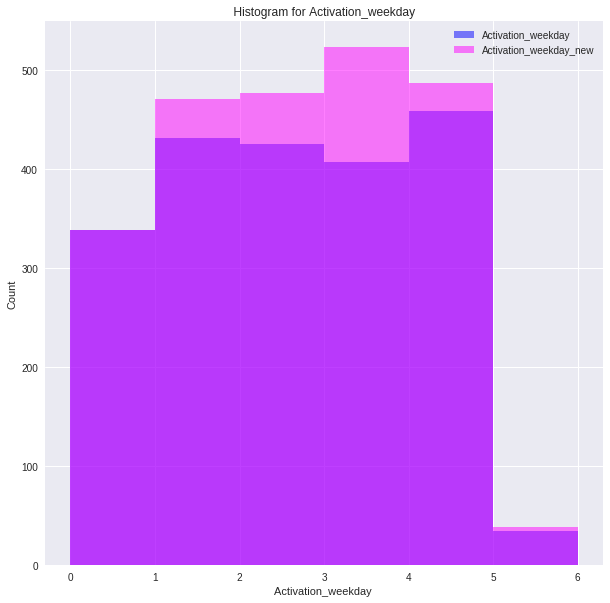

In [13]:
show_histogram(df_existing, ['Activation_weekday'], 7, df_new)

## Which weekdays are effective for renewals?

###Trends

1.   Over 98% renewals happen during the week from M-F. Sat-Sun are negligible.
2.   New Renewals alwasys exceed from existing with a range of 0-20%. Thu is best for new renewals.



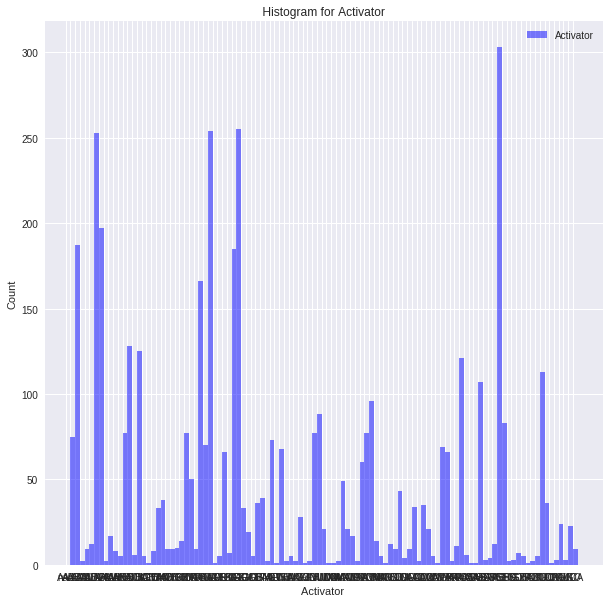

1 . STCH : 303
2 . FIOG : 255
3 . DAUM : 254
4 . ADEH : 253
5 . ADOL : 197
6 . ABBA : 187
7 . ESEK : 185
8 . DAOK : 166
9 . ANOD : 128
10 . BLUG : 125
11 . PROB : 121
12 . TOOD : 113
Over 50% of renewals ( 2287 ) were activated by  12 agents out of  108


In [14]:
#@title
# Which activator renews cusstomers more

key = 'Activator'
total_keys = len(df[key].unique())

show_histogram(df, [key], total_keys)

productive_activators = {};
for activator in df[key].unique():
  renewals = df.loc[df[key] == activator].Renewal_count.count()
  productive_activators[activator] = renewals

from operator import itemgetter
Top_activators = sorted(productive_activators.items(),
                        key=itemgetter(1), reverse=True)
top_renewals   = 0
total_renewals = df.Renewal_count.count()
i=0
for i in range(12):
  print(i+1, '.', Top_activators[i][0], ':', Top_activators[i][1] )
  top_renewals += Top_activators[i][1]
  if (100* (top_renewals/total_renewals) > 50):
    break;
print ("Over 50% of renewals (", top_renewals, ") were activated by ", 
       i+1, "agents out of ", total_keys)

## Who are my top performaing agents overall?

### Trends

Over 50% of renewals ( 2287 ) were activated by  12 agents ou of 108 agents.

1. STCH : 303
2. FIOG : 255
3. DAUM : 254
4. ADEH : 253
5. ADOL : 197
6. ABBA : 187
7. ESEK : 185
8. DAOK : 166
9. ANOD : 128
10. BLUG : 125
11. PROB : 121
12. TOOD : 113







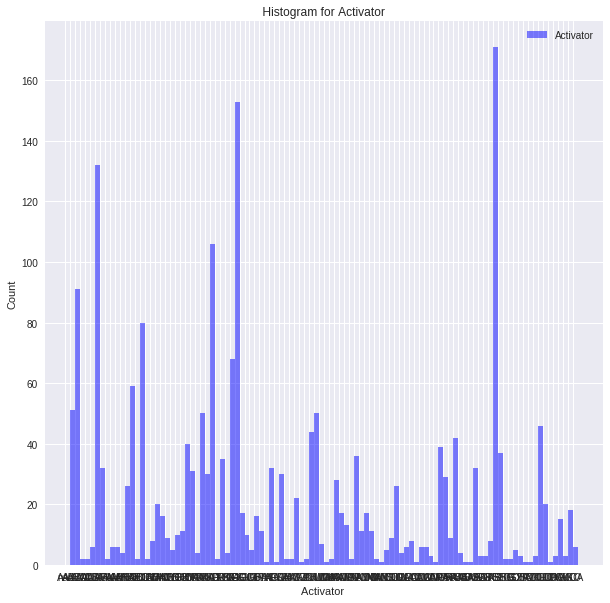

1 . STCH : 171
2 . FIOG : 153
3 . ADEH : 132
4 . DAUM : 106
5 . ABBA : 91
6 . BLUG : 80
7 . ESEK : 68
8 . ANOD : 59
9 . AAAA : 51
10 . JOUD : 50
11 . DAOK : 50
12 . TOOD : 46
Over 50% of renewals ( 1057 ) were activated by  12 agents out of  103


In [15]:
#@title
# Which activator renews existing customers more (loyalty rate)
# No Marketing Budget goes in renewing existing customers

key = 'Activator'
total_keys = len(df_existing[key].unique())

show_histogram(df_existing, [key], total_keys)

productive_activators = {};
for activator in df_existing[key].unique():
  renewals = df_existing.loc[df_existing[key] == activator].Renewal_count.count()
  productive_activators[activator] = renewals

from operator import itemgetter
Top_activators = sorted(productive_activators.items(),
                        key=itemgetter(1), reverse=True)
top_renewals   = 0
total_renewals = df_existing.Renewal_count.count()
i=0
for i in range(12):
  print(i+1, '.', Top_activators[i][0], ':', Top_activators[i][1] )
  top_renewals += Top_activators[i][1]
  if (100* (top_renewals/total_renewals) > 50):
    break;
print ("Over 50% of renewals (", top_renewals, ") were activated by ", 
       i+1, "agents out of ", total_keys)

## Which agent renews existing customers more (loyalty rate)?
Since mo Marketing Budget goes in renewing existing customerns, it is better return.

### Trends
Over 50% of renewals ( 1057 ) were activated by  12 agents out of  103.
1. STCH : 171
2. FIOG : 153
3. ADEH : 132
4. DAUM : 106
5. ABBA : 91
6. BLUG : 80
7. ESEK : 68
8. ANOD : 59
9. AAAA : 51
10. JOUD : 50
11. DAOK : 50
12. TOOD : 46



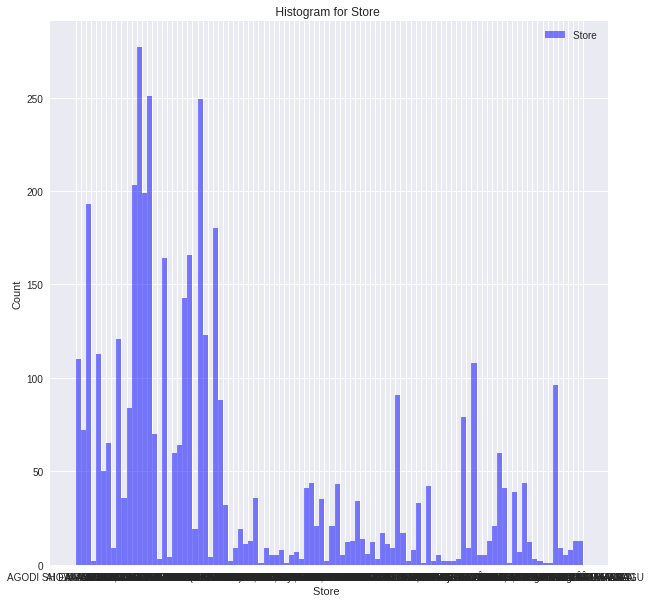

1 . AI LAGOS ILUPEJU : 277
2 . AI LAGOS OBA AKRAN : 251
3 . AI STORE ADEOLA ODEKU : 249
4 . AI LAGOS IKORODU : 203
5 . AI LAGOS LEKKI MALLL : 199
6 . AI ABUJA : 193
7 . AI STORE RINGROAD : 180
8 . AI SILVERBIRD GALLERIA : 166
9 . AI LAGOS SURULERE : 164
10 . AI SHOPRITE ENUGU : 143
11 . AI STORE IKEJA : 123
12 . AI KADUNA : 121
Over 50% of renewals ( 2269 ) were activated by  12 Stores out of  101


In [16]:
#@title
# Which Store renews more

key = 'Store '
total_keys = len(df[key].unique())

show_histogram(df, [key], total_keys)

productive_activators = {};
for activator in df[key].unique():
  renewals = df.loc[df[key] == activator].Renewal_count.count()
  productive_activators[activator] = renewals

from operator import itemgetter
Top_activators = sorted(productive_activators.items(),
                        key=itemgetter(1), reverse=True)
top_renewals = 0
i=0
for i in range(12):
  print(i+1, '.', Top_activators[i][0], ':', Top_activators[i][1] )
  top_renewals += Top_activators[i][1]
  if (100* (top_renewals/df.Renewal_count.count()) > 50):
    break;
print ("Over 50% of renewals (", top_renewals, ") were activated by ", 
       i+1, "Stores out of ", len(df[key].unique()) )

## Which stores are leading renewals?

### Trends
Over 50% of renewals ( 2269 ) were activated by  12 Stores out of 101 Stores.
1. AI LAGOS ILUPEJU : 277
2. AI LAGOS OBA AKRAN : 251
3. AI STORE ADEOLA ODEKU : 249
4. AI LAGOS IKORODU : 203
5. AI LAGOS LEKKI MALLL : 199
6. AI ABUJA : 193
7. AI STORE RINGROAD : 180
8. AI SILVERBIRD GALLERIA : 166
9. AI LAGOS SURULERE : 164
10. AI SHOPRITE ENUGU : 143
11. AI STORE IKEJA : 123
12. AI KADUNA : 121

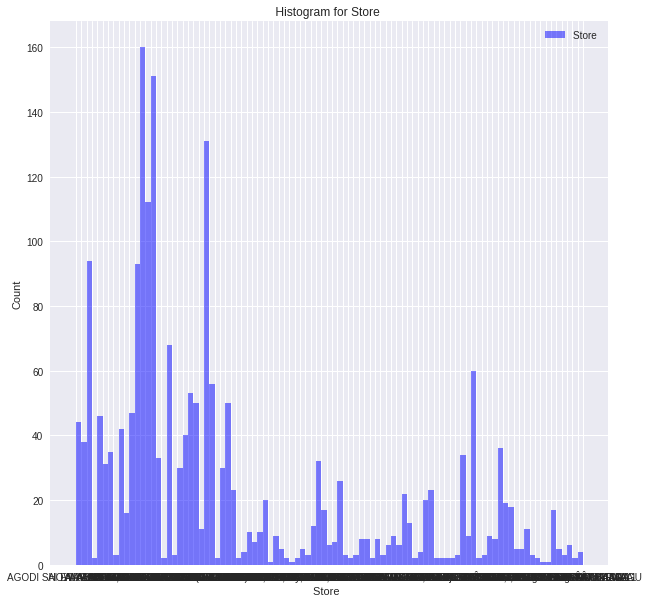

1 . AI LAGOS ILUPEJU : 160
2 . AI LAGOS OBA AKRAN : 151
3 . AI STORE ADEOLA ODEKU : 131
4 . AI LAGOS LEKKI MALLL : 112
5 . AI ABUJA : 94
6 . AI LAGOS IKORODU : 93
7 . AI LAGOS SURULERE : 68
8 . SL IKOTUN : 60
9 . AI STORE IKEJA : 56
10 . AI SHOPRITE ENUGU : 53
11 . AI UYO : 50
12 . AI SILVERBIRD GALLERIA : 50
Over 50% of renewals ( 1078 ) were activated by  12 Stores out of  96


In [17]:
#@title
# Which Store renews existing customers more (Loyalty rate). 
# No Marketing Budget goes in renewing existing customers

key = 'Store '
total_keys = len(df_existing[key].unique())

show_histogram(df_existing, [key], total_keys)

productive_activators = {};
for activator in df_existing[key].unique():
  renewals = df_existing.loc[df_existing[key] == activator].Renewal_count.count()
  productive_activators[activator] = renewals

from operator import itemgetter
Top_activators = sorted(productive_activators.items(),
                        key=itemgetter(1), reverse=True)
top_renewals = 0
i=0
for i in range(12):
  print(i+1, '.', Top_activators[i][0], ':', Top_activators[i][1] )
  top_renewals += Top_activators[i][1]
  if (100* (top_renewals/df_existing.Renewal_count.count()) > 50):
    break;
print ("Over 50% of renewals (", top_renewals, ") were activated by ", 
       i+1, "Stores out of ", len(df_existing[key].unique()) )

## Which stores foster loyalty in customers base?

### Trends
Over 50% of renewals ( 1078 ) were activated by  12 Stores out of  96.

1. AI LAGOS ILUPEJU : 160
2. AI LAGOS OBA AKRAN : 151
3. AI STORE ADEOLA ODEKU : 131
4. AI LAGOS LEKKI MALLL : 112
5. AI ABUJA : 94
6. AI LAGOS IKORODU : 93
7. AI LAGOS SURULERE : 68
8. SL IKOTUN : 60
9. AI STORE IKEJA : 56
10. AI SHOPRITE ENUGU : 53
11. AI UYO : 50
12. AI SILVERBIRD GALLERIA : 50

#Summary
We explored data present in the inputs and provided suggestions for underllying trends observed in.

---
© Rohit Sharma, March 2018